## Downloading data

In [1]:
!wget -O chicagoCrime.csv https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv
!wget https://www.dropbox.com/s/jdt0z8ypisz3iz4/Boundaries%20-%20Community%20Areas%20%28current%29.geojson
!wget https://www.dropbox.com/s/8q7nnlxm035ye41/Boundaries%20-%20ZIP%20Codes.geojson
!wget https://www.dropbox.com/s/o3nopvq5l5wutzu/communityZipCode.csv
!wget https://www.dropbox.com/s/1hzb28i6mfv2c38/populationPerCommunity.csv
!wget -O chicagoSchools.csv https://www.dropbox.com/s/9v6wdt1cdvsrbak/chicagoSchools.csv?dl=0

--2020-12-11 14:22:24--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199, 52.206.68.26, 52.206.140.205
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘chicagoCrime.csv’

chicagoCrime.csv        [      <=>           ]   1.59G  3.02MB/s    in 8m 46s  

2020-12-11 14:31:10 (3.09 MB/s) - ‘chicagoCrime.csv’ saved [1706717876]

--2020-12-11 14:31:10--  https://www.dropbox.com/s/jdt0z8ypisz3iz4/Boundaries%20-%20Community%20Areas%20%28current%29.geojson
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jdt0z8ypisz3iz4/Boundaries%20-%20Community%20Areas%20%28current%29.geojson [f

In [ ]:
# !pip install geopandas
# !pip install folium


## **Running Pyspark in Colab**

To run spark in Colab, we need to first install all the dependencies in Colab environment i.e. Apache Spark 2.3.2 with hadoop 2.7, Java 8 and Findspark to locate the spark in the system. The tools installation can be carried out inside the Jupyter Notebook of the Colab. One important note is that if you are new in Spark, it is better to avoid Spark 2.4.0 version since some people have already complained about its compatibility issue with python. 
Follow the steps to install the dependencies:

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

Now that you installed Spark and Java in Colab, it is time to set the environment path which enables you to run Pyspark in your Colab environment. Set the location of Java and Spark by running the following code:

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

Run a local spark session to test your installation:

In [4]:
import findspark
findspark.init()

In [5]:
findspark.find()

'/content/spark-3.0.1-bin-hadoop2.7'

The entry-point of any PySpark program is a SparkContext object. This object allows you to connect to a Spark cluster and create RDDs. The local[*] string is a special string denoting that you’re using a local cluster, which is another way of saying you’re running in single-machine mode. The * tells Spark to create as many worker threads as logical cores on your machine.

# Main Program

In [6]:
import pyspark
import pyspark.sql.functions as F # col
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import IntegerType

sc = pyspark.SparkContext(appName = "schoolAnalyticApp")
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

In [7]:
#load data parquet format
# communityDF = sqlContext.read.load("/user/vsc266/project/community.parquet",header = True, inferSchema = True)
# crimeDF = sqlContext.read.load("/user/vsc266/project/chiCrime.parquet",header = True, inferSchema = True)
# populationDF = sqlContext.read.load("/user/vsc266/project/populationPerCommunity.parquet",header = True, inferSchema = True)
# schoolDF = sqlContext.read.load("/user/vsc266/project/chicagoschool.parquet", header = True, inferSchema = True)


# load data csv format
communityDF = spark.read.format("csv").load("communityZipCode.csv", header = True, inferSchema = True)
crimeDF = spark.read.format("csv").load("chicagoCrime.csv", header = True, inferSchema = True)
populationDF = spark.read.format("csv").load("populationPerCommunity.csv", header = True, inferSchema = True)
schoolDF = spark.read.format("csv").load("chicagoSchools.csv", header = True, inferSchema = True)

In [8]:
schoolDF.count()

188

In [9]:
schoolDF.select("School ID","Zip Code").describe().show()

+-------+------------------+------------------+
|summary|         School ID|          Zip Code|
+-------+------------------+------------------+
|  count|               188|               188|
|   mean| 525162.1436170213|          60627.75|
| stddev|103300.29128117723|20.666080866863272|
|    min|            400010|             60602|
|    max|            610574|             60827|
+-------+------------------+------------------+



In [10]:
schoolDF.show()

+---------+--------------------+--------------------+-------+-----+--------+---------------+--------------------+-----------------+----------------------------+-----------------------------+----------------+----------------------------------+---------------------+---------------------+---------------+----------------------+---------------------+-----------------+----------------------+---------------+----------------+--------------------------+---------------------+-----------------------------+------------------------------+-----------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+--------------------------------------+---------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+---------------

In [11]:
len(schoolDF.toPandas()['School ID'].unique())

188

In [12]:
len(schoolDF.toPandas()['ZIP Code'].unique())

46

In [28]:
#differentiate bc other dataframes have same name
#rename to more user friendly names
crimeDF = crimeDF.withColumnRenamed("2017\xa0population","Population2017")
crimeDF = crimeDF.withColumnRenamed("Community Area","Community Area")
communityDF = communityDF.withColumnRenamed("CHGOCA","Community Area 2")
communityDF = communityDF.withColumnRenamed("ZCTA5", "Zip Code")
populationDF = populationDF.withColumnRenamed("Community Area","Community Area 3")
populationDF = populationDF.withColumnRenamed("2017\xa0population","Population2017")

#Drop TOT2010 not necessary column
communityDF  = communityDF.drop("TOT2010")

#Convert Population2017 from string to int
#drop the commas preventing being read as int
populationDF = populationDF.select("Community Area 3", F.translate(F.col("Population2017"), ",", "").alias("Population2017"), "Name")
# Find the crime rate per capita for each community using crime data
crimeDF17 = crimeDF.filter(crimeDF["Year"] == 2017)
#drop where the Community Area Values are null or 0 (which is also n)
crimeDFClean = crimeDF17.filter(crimeDF["Community Area"].isNotNull())
crimeDFClean = crimeDF17.filter(crimeDF["Community Area"] != 0 )
#contains community area + count for each community area
crimePerCapitaDF = crimeDFClean.groupby(crimeDFClean["Community Area"]).count()
#left join to add population data
crimePerCapitaDF = crimePerCapitaDF.join(populationDF,crimePerCapitaDF["Community Area"] == populationDF["Community Area 3"], how = "left")
crimePerCapitaDF = crimePerCapitaDF.select("Community Area", "Population2017", "Name", "count")
#find the ratio crime_count/population for each community
crimePerCapitaDF = crimePerCapitaDF.withColumn('perCapitaCrime', crimePerCapitaDF["count"]/crimePerCapitaDF["Population2017"])


countSchoolDF = schoolDF.groupby(schoolDF["Zip Code"]).count()
#left join with school count
countSchoolDF = countSchoolDF.join(schoolDF, countSchoolDF["Zip Code"]==schoolDF["Zip Code"],how = "left").drop(schoolDF["Zip Code"])
#left join with community area
countSchoolDF = countSchoolDF.join(communityDF,communityDF["Zip Code"]== countSchoolDF["Zip Code"], how = "left")
#groupby and count based on  community area
countSchoolDF = countSchoolDF.groupby(countSchoolDF["Community Area 2"]).count()
countSchoolDF = countSchoolDF.withColumnRenamed("count","countSchool")
finalDF = crimePerCapitaDF.join(countSchoolDF,countSchoolDF["Community Area 2"]==crimePerCapitaDF["Community Area"],how = "left")
finalDF = finalDF.fillna({"countSchool":0})
finalDF = finalDF.withColumn('perCapitaSchool', finalDF["countSchool"]/finalDF["Population2017"])
finallrDF = finalDF.select("perCapitaCrime","perCapitaSchool")
finallrDF.show()

#save analytic output to HDFS
finallrDF.coalesce(1).write.mode('overwrite').option('header','true').csv('/content/')


+--------------------+--------------------+
|      perCapitaCrime|     perCapitaSchool|
+--------------------+--------------------+
| 0.08005959620530284|5.777183167112624E-4|
| 0.05669324634529419|2.114292618098344...|
| 0.14422175762381947|4.325571335880614...|
| 0.07573392790784095|0.001189149015235...|
| 0.14418182974933197| 4.93065275480341E-4|
| 0.13638199886886967|3.231800921063262...|
|  0.3132319524558644|4.661189768688457...|
| 0.23879775955191038|9.001800360072014E-4|
| 0.20620179948586118|2.892030848329049E-4|
| 0.02886587097113413| 1.57736999842263E-4|
|  0.0695452180817567|2.874900747474194E-4|
| 0.16548358473824312|0.001330967169476...|
| 0.07549671279648397|7.264538156986669E-5|
| 0.05135442558031765|2.527699372287989...|
|0.051374588684852986|3.715104553656724...|
| 0.05733054643177068|1.990643973325370...|
| 0.05519539977291873| 1.83130058967879E-4|
| 0.06154589205319718|6.899763683093855E-5|
| 0.06241716368455931|4.141815772034459...|
| 0.23761085028690662|0.00191271

In [14]:
# Run if warning:- can't run multiple instances of spark session
# sc.stop()

# Detecting confounding variables (Detecting Multicollinearity using VIF)

In [20]:
import pandas as pd

In [21]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [31]:
finalDF.show()

+--------------+--------------+------------------+-----+--------------------+----------------+-----------+--------------------+
|Community Area|Population2017|              Name|count|      perCapitaCrime|Community Area 2|countSchool|     perCapitaSchool|
+--------------+--------------+------------------+-----+--------------------+----------------+-----------+--------------------+
|            31|         32888|   Lower West Side| 2633| 0.08005959620530284|              31|         19|5.777183167112624E-4|
|            65|         33108|         West Lawn| 1877| 0.05669324634529419|              65|          7|2.114292618098344...|
|            53|         27742|      West Pullman| 4001| 0.14422175762381947|              53|         12|4.325571335880614...|
|            34|         13455|     Armour Square| 1019| 0.07573392790784095|              34|         16|0.001189149015235...|
|            28|         62872|    Near West Side| 9065| 0.14418182974933197|              28|         3

In [39]:
finalDF = finalDF.withColumn('Population2017',F.col('Population2017').cast(IntegerType()))

In [41]:
X = finalDF.select('Community Area','Population2017','count','perCapitaCrime')
calc_vif(X.toPandas())

,variables,VIF
0,Community Area,2.962721
1,Population2017,5.012877
2,count,7.803749
3,perCapitaCrime,5.100433


# Linear Regression

In [ ]:
import pyspark 
from pyspark.sql import SparkSession 
#SparkSession is now the entry point of Spark 
#SparkSession can also be construed as gateway to spark libraries 

#create instance of spark class 
spark=SparkSession.builder.appName('ppc').getOrCreate() 

In [ ]:
lr_data = finalDF

In [ ]:
lr_pandas = lr_data.toPandas()
lr_pandas.to_csv('lr_output.csv')

In [ ]:
lr_data.show(10) 

+-------------------+--------------------+
|     perCapitaCrime|     perCapitaSchool|
+-------------------+--------------------+
|0.08005959620530284|5.777183167112624E-4|
|0.05669324634529419|2.114292618098344...|
|0.14422175762381947|4.325571335880614...|
|0.07573392790784095|0.001189149015235...|
|0.14418182974933197| 4.93065275480341E-4|
|0.13638199886886967|3.231800921063262...|
| 0.3132319524558644|4.661189768688457...|
|0.23879775955191038|9.001800360072014E-4|
|0.20620179948586118|2.892030848329049E-4|
|0.02886587097113413| 1.57736999842263E-4|
+-------------------+--------------------+
only showing top 10 rows



In [ ]:
lr_data.columns

['perCapitaCrime', 'perCapitaSchool']

In [ ]:
lr_data.printSchema()

root
 |-- perCapitaCrime: double (nullable = true)
 |-- perCapitaSchool: double (nullable = true)



In [ ]:
independent = 'perCapitaSchool'
# dependent = 'count'
dependent = 'perCapitaCrime'

## Creating vectors from features

In [ ]:
from pyspark.ml.linalg import Vectors 
from pyspark.ml.feature import VectorAssembler 
#creating vectors from features 
#Apache MLlib takes input if vector form 
assembler=VectorAssembler(inputCols=[independent],outputCol='features') 
output=assembler.transform(lr_data) 
output.select('features',independent,dependent).show(5) 
#output as below 

+--------------------+--------------------+-------------------+
|            features|     perCapitaSchool|     perCapitaCrime|
+--------------------+--------------------+-------------------+
|[5.77718316711262...|5.777183167112624E-4|0.08005959620530284|
|[2.11429261809834...|2.114292618098344...|0.05669324634529419|
|[4.32557133588061...|4.325571335880614...|0.14422175762381947|
|[0.00118914901523...|0.001189149015235...|0.07573392790784095|
|[4.93065275480341...| 4.93065275480341E-4|0.14418182974933197|
+--------------------+--------------------+-------------------+
only showing top 5 rows



## Train test split

In [ ]:
#final data consist of features and label which is crew. 
final_data=output.select('features',independent,dependent)
#splitting data into train and test 
train_data,test_data=final_data.randomSplit([0.60,0.40]) 
train_data.describe().show() 

+-------+--------------------+--------------------+
|summary|     perCapitaSchool|      perCapitaCrime|
+-------+--------------------+--------------------+
|  count|                  53|                  53|
|   mean|5.337416486441532E-4| 0.11308406444182534|
| stddev|5.194468529790961E-4| 0.07789703459414932|
|    min|5.187529179851637E-5|0.023696682464454975|
|    max|0.002870028700287003| 0.36080360803608036|
+-------+--------------------+--------------------+



In [ ]:
#import LinearRegression library 
from pyspark.ml.regression import LinearRegression 
#creating an object of class LinearRegression 
#object takes features and label as input arguments 
ship_lr=LinearRegression(featuresCol='features',labelCol=dependent) 
#pass train_data to train model 
trained_ship_model=ship_lr.fit(train_data) 
#evaluating model trained for Rsquared error 
ship_results=trained_ship_model.evaluate(train_data) 

print('Rsquared Error :',ship_results.r2) 
#R2 value shows accuracy of model is 97% 
#model accuracy is decent and can be used for predictive analysis 

Rsquared Error : 0.30033781842159624


In [ ]:
# https://stackoverflow.com/a/62321801/9292995
# https://mungingdata.com/pyspark/column-to-list-collect-tolocaliterator/
# this will return a list of the selected column, except the last row

# x = list(output.select('Community Area').toPandas()['Community Area'])[:-1]
# output.select('Community Area').rdd.map(lambda row : row[0]).collect()[:-1] # faster approach

In [ ]:
X_train = list(output.select(independent).toPandas()[independent])
Y_train = list(output.select(dependent).toPandas()[dependent])

In [ ]:
X_test = list(test_data.select(independent).toPandas()[independent])
Y_test = list(test_data.select(dependent).toPandas()[dependent])

In [ ]:
y_pred_spark = trained_ship_model.transform(test_data)
y_pred = (y_pred_spark.select('prediction').toPandas()['prediction'])

In [ ]:
train_data.show()

+--------------------+--------------------+--------------------+
|            features|     perCapitaSchool|      perCapitaCrime|
+--------------------+--------------------+--------------------+
|[0.00118914901523...|0.001189149015235...| 0.07573392790784095|
|[4.93065275480341...| 4.93065275480341E-4| 0.14418182974933197|
|[3.23180092106326...|3.231800921063262...| 0.13638199886886967|
|[4.66118976868845...|4.661189768688457...|  0.3132319524558644|
|[9.00180036007201...|9.001800360072014E-4| 0.23879775955191038|
|[2.89203084832904...|2.892030848329049E-4| 0.20620179948586118|
|[1.57736999842263...| 1.57736999842263E-4| 0.02886587097113413|
|[2.87490074747419...|2.874900747474194E-4|  0.0695452180817567|
|[0.00133096716947...|0.001330967169476...| 0.16548358473824312|
|[7.26453815698666...|7.264538156986669E-5| 0.07549671279648397|
|[2.52769937228798...|2.527699372287989...| 0.05135442558031765|
|[3.71510455365672...|3.715104553656724...|0.051374588684852986|
|[1.83130058967879...| 1.

In [ ]:
# import chart_studio.plotly as py
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=X_train,
        y=Y_train,
        mode='markers',
        name='Train'
    ))
fig.add_trace(
    go.Scatter(
        x=X_test,
        y=y_pred,
        name='Predicted',
        mode='lines+markers'
    ))
fig.update_layout(
    title="Linear Regression",
    xaxis_title="Schools per Capita",
    yaxis_title="Crime per Capita",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)
fig.show()

In [ ]:
lr_data.show()

+--------------------+--------------------+
|      perCapitaCrime|     perCapitaSchool|
+--------------------+--------------------+
| 0.08005959620530284|5.777183167112624E-4|
| 0.05669324634529419|2.114292618098344...|
| 0.14422175762381947|4.325571335880614...|
| 0.07573392790784095|0.001189149015235...|
| 0.14418182974933197| 4.93065275480341E-4|
| 0.13638199886886967|3.231800921063262...|
|  0.3132319524558644|4.661189768688457...|
| 0.23879775955191038|9.001800360072014E-4|
| 0.20620179948586118|2.892030848329049E-4|
| 0.02886587097113413| 1.57736999842263E-4|
|  0.0695452180817567|2.874900747474194E-4|
| 0.16548358473824312|0.001330967169476...|
| 0.07549671279648397|7.264538156986669E-5|
| 0.05135442558031765|2.527699372287989...|
|0.051374588684852986|3.715104553656724...|
| 0.05733054643177068|1.990643973325370...|
| 0.05519539977291873| 1.83130058967879E-4|
| 0.06154589205319718|6.899763683093855E-5|
| 0.06241716368455931|4.141815772034459...|
| 0.23761085028690662|0.00191271

In [ ]:
import statsmodels.formula.api as smf
results = smf.ols('perCapitaCrime ~ perCapitaSchool', data=lr_data.toPandas()).fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



                            OLS Regression Results                            
Dep. Variable:         perCapitaCrime   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     27.12
Date:                Tue, 08 Dec 2020   Prob (F-statistic):           1.62e-06
Time:                        06:05:49   Log-Likelihood:                 103.44
No. Observations:                  77   AIC:                            -202.9
Df Residuals:                      75   BIC:                            -198.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0699      0.010     

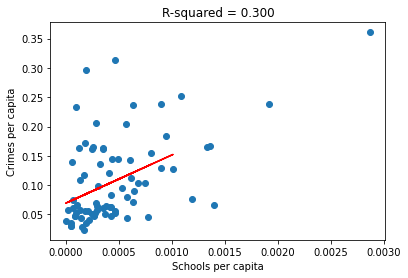

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(X_train, Y_train)
plt.plot(X_test, y_pred, color='red')
plt.title("R-squared = {:.3f}".format(ship_results.r2))
plt.xlabel("Schools per capita")
plt.ylabel("Crimes per capita")
plt.show()

In [ ]:
lr_pandas

,perCapitaCrime,perCapitaSchool
0,0.080060,0.000578
1,0.056693,0.000211
2,0.144222,0.000433
3,0.075734,0.001189
4,0.144182,0.000493
...,...,...
72,0.162368,0.000354
73,0.232584,0.000100
74,0.044035,0.000145
75,0.030347,0.000052


# Data Exploration

In [ ]:
crimeDF.count(), len(crimeDF.columns)

(7238485, 22)

In [ ]:
crimeDF.show(5)

+--------+-----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|      ID|Case Number|               Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|Latitude|Longitude|Location|
+--------+-----------+-------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+--------+---------+--------+
|11034701|   JA366925|2001-01-01 11:00:00|     016XX E 86TH PL|1153| DECEPTIVE PRACTICE|FINANCIAL IDENTIT...|           RESIDENCE| false|   false|0412|     004|   8|            45|      11| 

In [ ]:
# First showed the Boolean count of Community Area and Primary Type (Crime Type)
crimeDF.groupBy('Community Area').count().orderBy("count", ascending=False).show(20)

+--------------+------+
|Community Area| count|
+--------------+------+
|          null|613484|
|            25|419257|
|             8|229930|
|            43|217168|
|            23|209287|
|            28|196922|
|            24|194552|
|            29|193549|
|            67|193425|
|            71|188120|
|            49|176841|
|            68|175618|
|            69|164063|
|            66|163088|
|            32|161208|
|            44|144120|
|            22|138714|
|            61|135375|
|             6|132122|
|            26|125514|
+--------------+------+
only showing top 20 rows



In [ ]:
crimeDF.groupBy('Primary Type').count().orderBy("count", ascending=False).show(20)

+--------------------+-------+
|        Primary Type|  count|
+--------------------+-------+
|               THEFT|1527267|
|             BATTERY|1326031|
|     CRIMINAL DAMAGE| 824446|
|           NARCOTICS| 735061|
|             ASSAULT| 458398|
|       OTHER OFFENSE| 449116|
|            BURGLARY| 407276|
| MOTOR VEHICLE THEFT| 333380|
|  DECEPTIVE PRACTICE| 300709|
|             ROBBERY| 272090|
|   CRIMINAL TRESPASS| 204909|
|   WEAPONS VIOLATION|  85191|
|        PROSTITUTION|  69366|
|PUBLIC PEACE VIOL...|  50717|
|OFFENSE INVOLVING...|  50145|
| CRIM SEXUAL ASSAULT|  28055|
|         SEX OFFENSE|  27628|
|INTERFERENCE WITH...|  17453|
|            GAMBLING|  14594|
|LIQUOR LAW VIOLATION|  14450|
+--------------------+-------+
only showing top 20 rows



In [ ]:
# Print out schema to see what data type Arrest is. It's String type
crimeDF.printSchema() # Thus, in the filter must be string too, 'true'. If boolean type, True

root
 |-- ID: string (nullable = true)
 |-- Case Number: string (nullable = true)
 |-- Date: timestamp (nullable = true)
 |-- Block: string (nullable = true)
 |-- IUCR: string (nullable = true)
 |-- Primary Type: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Location Description: string (nullable = true)
 |-- Arrest: string (nullable = true)
 |-- Domestic: string (nullable = true)
 |-- Beat: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Ward: string (nullable = true)
 |-- Community Area: string (nullable = true)
 |-- FBI Code: string (nullable = true)
 |-- X Coordinate: string (nullable = true)
 |-- Y Coordinate: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Updated On: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [ ]:
crimeDF.select('Year').show(15)

+----+
|Year|
+----+
|2001|
|2017|
|2017|
|2017|
|2017|
|2015|
|2017|
|2017|
|2017|
|2017|
|2017|
|2012|
|2017|
|2017|
|2017|
+----+
only showing top 15 rows



In [ ]:
crimeDF.where(col("Location").isNotNull()).show()

+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|               Date|               Block|IUCR|        Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+-------------------+--------------------+----+--------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|11665567|   JC234307|2019-04-10 16:37:00|  102XX S VERNON AVE|1562|         SEX OFFENSE|AGGRAVATED CRIMIN...|SCHOOL - PUBLIC B

## Interactive plotly charts
- you can interact with the legends and pie chart

In [ ]:
import plotly.graph_objs as go
import plotly.express as px

In [ ]:
tot = crimeDFClean.count()

CA_pop_per = crimeDFClean.groupBy("Community Area") \
  .count() \
  .withColumnRenamed('count', 'cnt_per_community') \
  .withColumn('perc_of_count_total', (F.col('cnt_per_community') / tot) * 100 ) \
  .orderBy('Community Area') \
  .toPandas()
CA_pop_per

,Community Area,cnt_per_community,perc_of_count_total
0,1,4157,1.547107
1,2,3601,1.340181
2,3,3568,1.327900
3,4,2009,0.747688
4,5,1427,0.531085
...,...,...,...
72,73,3095,1.151864
73,74,585,0.217719
74,75,2122,0.789743
75,76,1688,0.628222


In [ ]:
fig = go.Figure(data=[go.Pie(labels=CA_pop_per['Community Area'], values=CA_pop_per['perc_of_count_total'], hovertemplate = "Community no.: %{label} <br>Crime Rate: %{percent}")])
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig.update_traces(textposition='inside', hoverinfo='label+percent',
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Crime rate per Community Area')
fig.show()

In [ ]:
data = [go.Bar(x=CA_pop_per['Community Area'], y=CA_pop_per['perc_of_count_total'], 
               text = 'crime percentage', hovertext=['perc_of_count_total'],
               marker={'color': CA_pop_per['perc_of_count_total'], 'colorscale': 'YlOrRd', "showscale": True}, 
               )]
layout = go.Layout(xaxis=dict(type='category'))
fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(
        tickangle = 90,
        title_text = "Community Area",)
fig.update_yaxes(
        title_text = "Percentage of Total Crime 2017")
fig.update_layout(title="2017 Crime rate by Community Area", hovermode='x')
fig.show()

In [ ]:
tot = crimeDFClean.count()

crime_per = crimeDFClean.groupBy("Primary Type") \
  .count() \
  .withColumnRenamed('count', 'crime type') \
  .withColumn('perc_of_count_total', (F.col('crime type') / tot) * 100 ) \
  .orderBy('Primary Type') \
  .toPandas()

In [ ]:
fig = go.Figure(data=[go.Pie(labels=crime_per['Primary Type'], values=crime_per['perc_of_count_total'])])
colors = ['gold', 'mediumturquoise', 'darkorange', 'lightgreen']
fig.update_traces(textposition='inside', hoverinfo='label+percent',
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(title_text='Crime types')
fig.show()

In [ ]:
data = [go.Bar(x=crime_per['Primary Type'], y=crime_per['perc_of_count_total'], 
               text = 'crime percentage', hovertext=['perc_of_count_total'],
               marker={'color': crime_per['perc_of_count_total'], 'colorscale': 'YlOrRd', "showscale": True}, 
               )]
layout = go.Layout(xaxis=dict(type='category'))
fig = go.Figure(data=data, layout=layout)
fig.update_xaxes(
        tickangle = 90,
        title_text = "Crime Type",)
fig.update_yaxes(
        title_text = "Crime rate")
fig.update_layout(title="Crime rate by Type", hovermode='x')
fig.show()

## Choropleth map

Download **Boundaries - Community Areas (current).geojson**

In [ ]:
!pip install folium geopandas
import folium
import geopandas

     |████████████████████████████████| 972kB 2.5MB/s 
     |████████████████████████████████| 14.8MB 1.2MB/s 
     |████████████████████████████████| 6.5MB 47.9MB/s 


In [ ]:
ca_boundaries = geopandas.read_file("Boundaries - Community Areas (current).geojson")
ca_boundaries

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ..."
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ..."
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ..."
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ..."
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ..."
...,...,...,...,...,...,...,...,...,...,...
72,MOUNT GREENWOOD,0,75584290.0209,0,74,74,0,0,48665.1305392,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ..."
73,MORGAN PARK,0,91877340.6988,0,75,75,0,0,46396.419362,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ..."
74,OHARE,0,371835607.687,0,76,76,0,0,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ..."
75,EDGEWATER,0,48449990.8397,0,77,77,0,0,31004.8309456,"MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ..."


In [ ]:
import pandas as pd
crimePerCapitaDFPandas = crimePerCapitaDF.toPandas()
crimePerCapitaDFPandas['Community Area'] = crimePerCapitaDFPandas['Community Area'].astype(str)

In [ ]:
map_data = ca_boundaries.merge(
    crimePerCapitaDFPandas,
    how="left",
    left_on="area_numbe",
    right_on="Community Area",
)
map_data

,community,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry,Community Area,Population2017,Name,count,perCapitaCrime
0,DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",35,20781,Douglas,2634,0.126750
1,OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",36,6645,Oakland,687,0.103386
2,FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",37,2439,Fuller Park,880,0.360804
3,GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...",38,22313,Grand Boulevard,3464,0.155246
4,KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...",39,17189,Kenwood,1537,0.089418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,MOUNT GREENWOOD,0,75584290.0209,0,74,74,0,0,48665.1305392,"MULTIPOLYGON (((-87.69646 41.70714, -87.69644 ...",74,19277,Mount Greenwood,585,0.030347
73,MORGAN PARK,0,91877340.6988,0,75,75,0,0,46396.419362,"MULTIPOLYGON (((-87.64215 41.68508, -87.64249 ...",75,22394,Morgan Park,2122,0.094758
74,OHARE,0,371835607.687,0,76,76,0,0,173625.98466,"MULTIPOLYGON (((-87.83658 41.98640, -87.83658 ...",76,12377,O'Hare,1688,0.136382
75,EDGEWATER,0,48449990.8397,0,77,77,0,0,31004.8309456,"MULTIPOLYGON (((-87.65456 41.99817, -87.65456 ...",77,55965,Edgewater,2642,0.047208


In [ ]:
# from branca.element import Figure

# fig=Figure(width=550,height=350)
#definition of the boundaries in the map

Chicago_COORDINATES = (41.895140898, -87.624255632)
district_geo = r'Boundaries - Community Areas (current).geojson'

#creating choropleth map for Chicago District 2016
map1 = folium.Map(location=Chicago_COORDINATES, zoom_start=11)
choropleth = folium.Choropleth(geo_data = district_geo,
                data = map_data,
                columns = ['Community Area', 'perCapitaCrime'],
                key_on = 'feature.properties.area_numbe',
                fill_color='YlOrRd',
                fill_opacity = 0.7, 
                line_opacity = 0.2,
                legend_name = 'Crime rate',
                highlight = True,
                overlay = True).add_to(map1)

# fig.add_child(map1)
# folium.TileLayer('Stamen Terrain').add_to(map1)
# folium.TileLayer('Stamen Toner').add_to(map1)
# folium.TileLayer('Stamen Water Color').add_to(map1)
# folium.TileLayer('cartodbpositron').add_to(map1)
# folium.TileLayer('cartodbdark_matter').add_to(map1)
# folium.LayerControl().add_to(map1)

# Display Region Label
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['community','area_numbe']))
# folium.Choropleth.add_child(
#     folium.features.GeoJsonTooltip(child = ['Name'],labels=True)
# ).add_to(map1)
# choropleth.geojson.add_child(folium.features.GeoJsonTooltip(
#         fields=['NAZEV_NUTS','cena_mean', 'cena_m2_mean'],
#         aliases=['Název kraje', 'Průměrná cena', 'Průměrná cena za m2'],
#         style=('background-color: grey; color: white;')
#         )
# )
map1

Output hidden; open in https://colab.research.google.com to view.